In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [ ]:
# utils
import torch
import torch.nn as nn

class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


def train(model, train_loader, train_N, random_trans, optimizer, loss_function):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_trans(x))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate(model, valid_loader, valid_N, loss_function):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [ ]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("mnist/sign_mnist_train.csv")
valid_df = pd.read_csv("mnist/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

In [ ]:
class MyConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, dropout_p):
    kernel_size = 3
    super().__init__()

    self.model = nn.Sequential(
       nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
       nn.BatchNorm2d(out_ch),
       nn.ReLU(),
       nn.Dropout(dropout_p),
       nn.MaxPool2d(2, stride=2)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
flattened_img_size = 75 * 3 * 3

base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3

    # flatten to dense layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)

)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin

In [ ]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

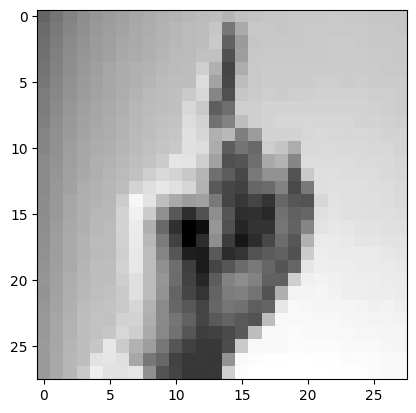

In [ ]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

In [ ]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7,1), ratio=(1,1))
])

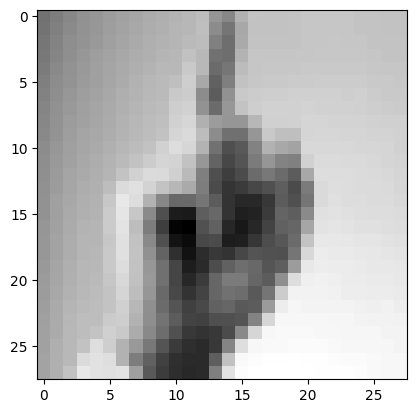

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
new_x_0.shape

torch.Size([1, 28, 28])

In [ ]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

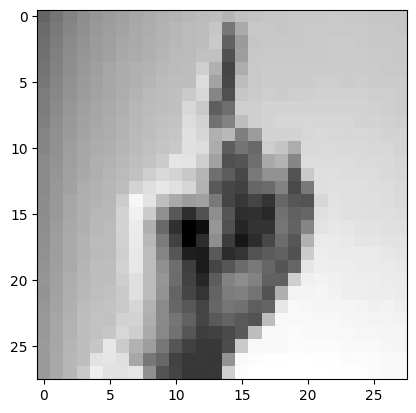

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

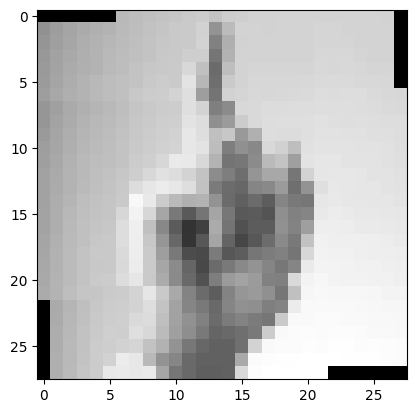

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

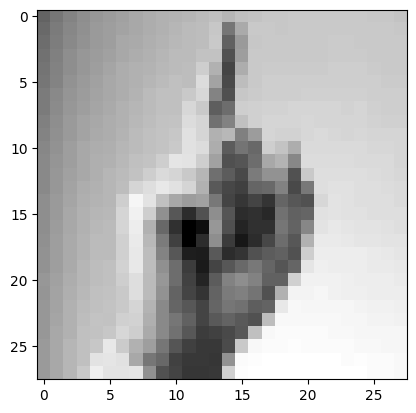

In [ ]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

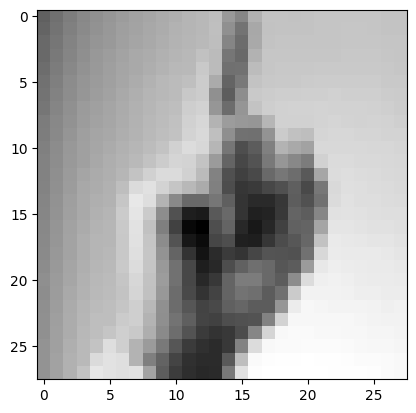

In [ ]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [ ]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0


W0416 16:46:01.984000 200 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Train - Loss: 665.0166 Accuracy: 0.7441
Valid - Loss: 58.7577 Accuracy: 0.9070
Epoch: 1
Train - Loss: 100.8063 Accuracy: 0.9636
Valid - Loss: 23.5450 Accuracy: 0.9697
Epoch: 2
Train - Loss: 60.4851 Accuracy: 0.9763
Valid - Loss: 23.3822 Accuracy: 0.9685
Epoch: 3
Train - Loss: 41.2127 Accuracy: 0.9847
Valid - Loss: 17.1999 Accuracy: 0.9776
Epoch: 4
Train - Loss: 35.6121 Accuracy: 0.9863
Valid - Loss: 27.8690 Accuracy: 0.9626
Epoch: 5
Train - Loss: 29.8727 Accuracy: 0.9887
Valid - Loss: 15.5251 Accuracy: 0.9812
Epoch: 6
Train - Loss: 25.2398 Accuracy: 0.9899
Valid - Loss: 20.0919 Accuracy: 0.9688
Epoch: 7
Train - Loss: 19.8627 Accuracy: 0.9925
Valid - Loss: 21.6141 Accuracy: 0.9692
Epoch: 8
Train - Loss: 20.5676 Accuracy: 0.9924
Valid - Loss: 8.5632 Accuracy: 0.9876
Epoch: 9
Train - Loss: 19.7446 Accuracy: 0.9923
Valid - Loss: 11.2527 Accuracy: 0.9833
Epoch: 10
Train - Loss: 23.3676 Accuracy: 0.9913
Valid - Loss: 10.0726 Accuracy: 0.9927
Epoch: 11
Train - Loss: 15.0211 Accuracy: 0.9945
V

In [ ]:
torch.save(base_model.state_dict(), 'model.pth')

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [ ]:
model = nn.Sequential(
    MyConvBlock(1, 25, 0.2),
    MyConvBlock(25, 50, 0.2),
    MyConvBlock(50, 75, 0.2),
    nn.Flatten(),
    nn.Linear(75*3*3, 512),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 24)
)
model.load_state_dict(torch.load('model.pth', map_location=device))
model.to(device)
model.eval()

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
ls -al

total 10131
drwx------ 2 root root    4096 Apr 12 16:46  AnomalyDINO_12_04_2025/
drwx------ 2 root root    4096 Apr 12 09:29 'Colab Notebooks'/
drwx------ 2 root root    4096 Sep 27  2019  dersler/
-rw------- 1 root root 2305967 Jan 25  2024  fenerbahçe.png
-rw------- 1 root root  164117 Nov  7  2023  image.png
drwx------ 2 root root    4096 Apr 12 18:38  .ipynb_checkpoints/
drwx------ 2 root root    4096 Apr 12 08:43  mem_seg/
drwx------ 2 root root    4096 Apr 16 15:14  mnist/
-rw------- 1 root root 1632273 Apr 16 16:49  model.pth
-rw------- 1 root root 6055298 Apr 29  2023  northern-lights-aurora-borealis-4k-fz.jpg
drwx------ 2 root root    4096 Apr 12 18:23  STPM_12_04_2024/
-rw------- 1 root root     994 Jan 12  2024 'Telegram Desktop - Kısayol.lnk'
drwx------ 2 root root    4096 Apr 12 17:51  transfusion_12_04_2025/
-rw------- 1 root root  103428 Jan  4  2024  WIN_20240104_20_54_38_Pro.jpg
-rw------- 1 root root   77801 Jan  4  2024  WIN_20240104_21_28_26_Pro.jpg


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

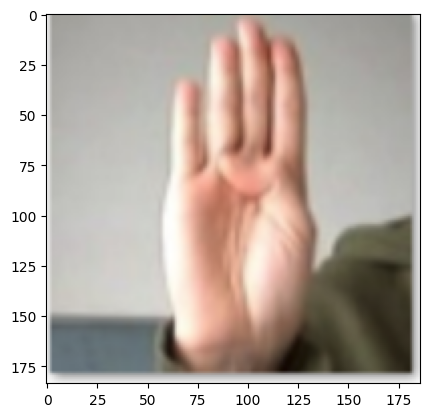

In [ ]:
show_image('mnist/asl_images/b.png')

In [ ]:
image = tv_io.read_image('mnist/asl_images/b.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[247, 223, 178,  ..., 223, 231, 238],
         [245, 221, 178,  ..., 213, 223, 232],
         [244, 220, 177,  ..., 204, 217, 228],
         ...,
         [247, 243, 238,  ..., 223, 231, 238],
         [249, 246, 243,  ..., 232, 238, 243],
         [250, 248, 246,  ..., 240, 243, 246]]], dtype=torch.uint8)

In [ ]:
image.shape

torch.Size([1, 184, 186])

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

In [ ]:
processed_image = preprocess_trans(image)
processed_image

tensor([[[0.6960, 0.6279, 0.6348, 0.6493, 0.6584, 0.6599, 0.6638, 0.6630,
          0.6652, 0.6677, 0.6711, 0.6696, 0.6661, 0.6677, 0.7103, 0.6559,
          0.6369, 0.6507, 0.6464, 0.6379, 0.6293, 0.6216, 0.6139, 0.6074,
          0.5984, 0.5895, 0.5836, 0.6977],
         [0.7013, 0.6388, 0.6480, 0.6578, 0.6647, 0.6687, 0.6709, 0.6734,
          0.6746, 0.6794, 0.6814, 0.6784, 0.6902, 0.6801, 0.7648, 0.6606,
          0.5610, 0.6348, 0.6418, 0.6509, 0.6417, 0.6308, 0.6252, 0.6197,
          0.6095, 0.6007, 0.5923, 0.6773],
         [0.7061, 0.6479, 0.6588, 0.6668, 0.6743, 0.6811, 0.6845, 0.6848,
          0.6872, 0.6898, 0.6913, 0.6909, 0.7671, 0.6833, 0.6945, 0.6803,
          0.4720, 0.6061, 0.5686, 0.6548, 0.6566, 0.6471, 0.6380, 0.6273,
          0.6198, 0.6124, 0.6078, 0.6837],
         [0.7165, 0.6603, 0.6699, 0.6770, 0.6821, 0.6880, 0.6959, 0.7001,
          0.7027, 0.7014, 0.7009, 0.7041, 0.8257, 0.6885, 0.6387, 0.7202,
          0.4938, 0.6614, 0.5266, 0.6351, 0.6649, 0.6595,

In [ ]:
processed_image.shape

torch.Size([1, 28, 28])

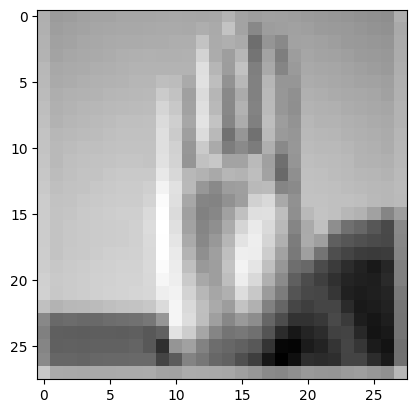

In [ ]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

In [ ]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

In [ ]:
output = model(batched_image_gpu)
output

tensor([[-25.7991,  15.8788,  -8.3599, -22.4153,  -3.3135, -19.3028, -13.1808,
         -26.9109, -12.6016, -16.2930, -14.3343, -10.5895, -10.3364, -21.4737,
          -9.9340, -18.9459, -11.7311, -24.2815, -20.0754,   3.8547, -15.2373,
          -7.0877,  -7.7701, -25.1176]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
prediction = output.argmax(dim=1).item()
prediction

1

In [ ]:
alphabet = "abcdefghiklmnopqrstuvwxy"

In [ ]:
alphabet[prediction]

'b'

In [ ]:
def predict_letter(file_path):
    show_image(file_path)
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    image = preprocess_trans(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    prediction = output.argmax(dim=1).item()
    # convert prediction to letter
    predicted_letter = alphabet[prediction]
    return predicted_letter

'b'

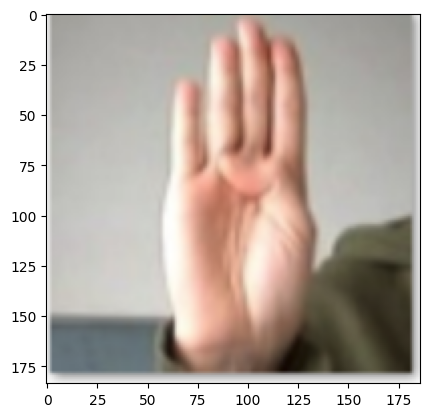

In [ ]:
predict_letter("mnist/asl_images/b.png")

'a'

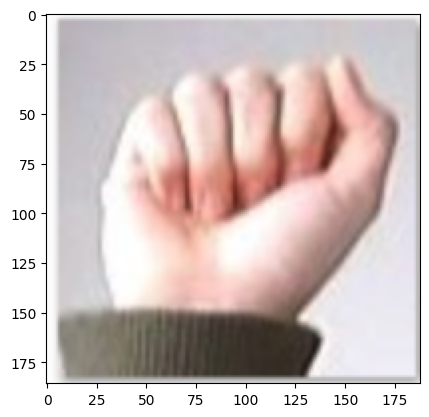

In [ ]:
predict_letter("mnist/asl_images/a.png")